In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
import warnings
import os
warnings.filterwarnings("ignore")

Kaggle에서 현재 진행중인 아래와 같은 2개의 competition 각각에 대해, 
- Predict Future Sales: 회귀문제, RMSE로 평가
- Categorical Feature Encoding Challenge: 분류문제, ROC-AUC로 평가

선택한 Code들의 submission을 조합하여 averaging한 결과를 만들고, 이를 Kaggle에 submit하여 과연 성능이 얼마나 향상되는지(즉, Leaderboard score의 개선) 확인

- 산술평균(arithmetic mean), 가중평균(weighted mean), 기하평균(geometric mean), 멱평균(Power mean)을 각각 적용할 것.
- 성능이 비슷한 submission 중에 가급적 서로간의 correlation이 낮은 submission을 선택하는게 바람직하다고 알려져 있으나 다양한 조합에 대한 반복 실험을 통해 확인할 것. 
- 회귀문제와 분류문제(또는 RMSE와 AUC)에 따라 averaging 효과가 다른지도 확인할 것.

### 서브미션 선정 방식

In [49]:
folder = '분류고성능submission'
nf = 0
for f in os.listdir(folder):
    ext = os.path.splitext(f)[-1]
    if ext == '.csv': 
        s = pd.read_csv(folder+"/"+f)
    else: 
        continue
    if len(s.columns) !=2:
        continue
    if nf == 0: 
        slist = s
    else: 
        slist = pd.merge(slist, s, on="id")
    nf += 1

In [50]:
df1=slist.iloc[:,1:]
df1.columns=[0,1,2,3,4,5,6,7]

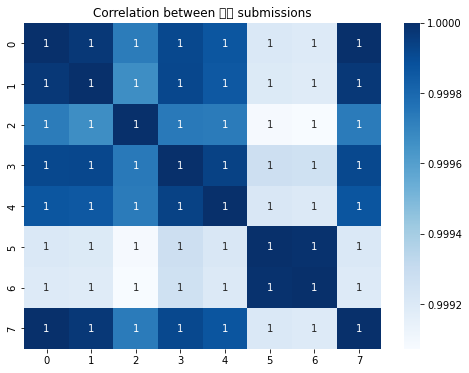

In [51]:
plt.figure(figsize = (8,6))
g = sns.heatmap(df1.corr(),annot=True, cmap='Blues')
g.set_title("Correlation between 분류 submissions")
plt.show()

In [52]:
folder ='회귀고성능submission'
nf = 0
score=[]
for f in os.listdir(folder):
    ext = os.path.splitext(f)[-1]
    if ext == '.csv': 
        s = pd.read_csv(folder+"/"+f)
    else: 
        continue
    score_1=(os.path.splitext(f)[-2].split(" "))[-1]
    score.append(score_1)
    if len(s.columns) !=2:
        continue
    if nf == 0: 
        slist = s
    else: 
        slist = pd.merge(slist, s, on="ID")
    nf += 1
print(score)

['0.83386', '0.83794', '0.84017', '0.85389', '0.86290', '0.86371', '0.86459', '0.86513']


In [53]:
ko=[3,4,0,1,2,5,6,7]
df1=slist.iloc[:,1:]
df1.columns=ko
df1=df1[[0,1,2,3,4,5,6,7]]

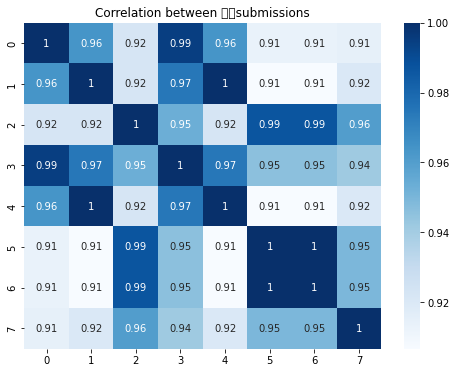

In [54]:
plt.figure(figsize = (8,6))
g = sns.heatmap(df1.corr(),annot=True, cmap='Blues')
g.set_title("Correlation between 회귀submissions")
plt.show()

## 분류문제

#### 0.8085 이 공개된 코드에서 가장 좋은 점수

In [55]:
folder = '분류submission'
nf = 0
score=[]
for f in os.listdir(folder):
    ext = os.path.splitext(f)[-1]
    if ext == '.csv': 
        s = pd.read_csv(folder+"/"+f)
    else: 
        continue
    score_1=(os.path.splitext(f)[-2].split(" "))[-1]
    score.append(score_1)
    if len(s.columns) !=2:
        continue
    if nf == 0: 
        slist = s
    else: 
        slist = pd.merge(slist, s, on="id")
    nf += 1
print(score)

['0.77931', '0.80399', '0.80175', '0.80314', '0.80038', '0.79556', '0.80531', '0.75788', '0.80289']


In [56]:
ko=[7,1,4,2,5,6,0,8,3]

In [57]:
df1=slist.iloc[:,1:]
df1.columns=ko
df1=df1[[0,1,2,3,4,5,6,7,8]]

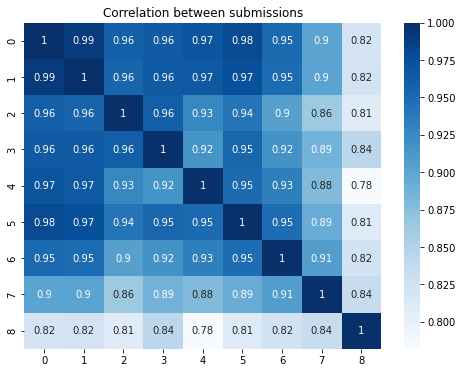

In [58]:
plt.figure(figsize = (8,6))
g = sns.heatmap(df1.corr(),annot=True, cmap='Blues')
g.set_title("Correlation between submissions")
plt.show()

### (1) 전부다 앙상블 했을 때

In [59]:
from scipy.stats.mstats import gmean
result_1=np.arange(0,9)
gm=gmean([ df1.iloc[:,x] for x in result_1])
wm=np.average([ df1.iloc[:,x] for x in result_1],axis=0,weights=[len(ko)-x for x in result_1])

In [60]:
from scipy.stats.mstats import gmean
subgm=slist.iloc[:,:1].copy(); subgm["target"]=gm # 
subwm=slist.iloc[:,:1].copy(); subwm["target"]=wm  # 

subgm.set_index("id").to_csv("1.submission분류_기하평균.csv")
subwm.set_index("id").to_csv("1.submission분류_가중평균.csv")

In [61]:
def avg(p,k=" ",NUM=" "):
    pred = 0
    for j in range(nf): pred = pred + slist.iloc[:,j+1]**p 
    pred = pred / nf    
    pred = pred**(1/p)

    submission = pd.DataFrame({'id': slist.id, 'target': pred})
    t = pd.Timestamp.now()
    fname = f"{NUM}. p{p}mean_submission{k}_{t.month:02}{t.day:02}_{t.hour:02}{t.minute:02}.csv"
    submission.to_csv(fname, index=False)

avg(1,"_분류_산술평균",NUM="1")   #
avg(2,"_분류",NUM="1")   #
avg(3.5,"_분류",NUM="1") #
avg(5,"_분류",NUM="1")   #

### (2) 점수가 좋은 것끼리 앙상블 한 경우

In [62]:
result_1=[0,1,2,3]
gm=gmean([ df1.iloc[:,x] for x in result_1])
wm=np.average([ df1.iloc[:,x] for x in result_1],axis=0,weights=[4,3,2,1])

In [63]:
subgm=slist.iloc[:,:1].copy(); subgm["target"]=gm #
subwm=slist.iloc[:,:1].copy(); subwm["target"]=wm #

subgm.set_index("id").to_csv("2.submission분류_기하평균.csv")
subwm.set_index("id").to_csv("2.submission분류_가중평균.csv")

In [64]:
slist1=df1[result_1]
nf=len(result_1)

In [65]:
avg(1,"_분류_산술평균","2")   #
avg(2,"_분류",NUM="2")   #
avg(3.5,"_분류",NUM="2") #
avg(5,"_분류",NUM="2")   #

### (3) 가장 점수가 좋은 것과 상관관계가 높은 것끼리 했을 때

In [66]:
result_1=[0,1,4,5]
gm=gmean([ df1.iloc[:,x] for x in result_1])
wm=np.average([ df1.iloc[:,x] for x in result_1],axis=0,weights=[4,3,2,1])

In [67]:
subgm=slist.iloc[:,:1].copy(); subgm["target"]=gm #
subwm=slist.iloc[:,:1].copy(); subwm["target"]=wm  #

subgm.set_index("id").to_csv("3.submission분류_기하평균.csv")
subwm.set_index("id").to_csv("3.submission분류_가중평균.csv")

In [68]:
slist1=df1[result_1]
nf=len(result_1)

In [69]:
avg(1,"_분류_산술평균","3")   #
avg(2,"_분류",NUM="3")   #
avg(3.5,"_분류",NUM="3") #
avg(5,"_분류",NUM="3")   #

### (4) 가장 점수가 좋은 것과 상관관계가 낮은 것끼리 했을 때

In [70]:
result_1=[0,6,7,8]
gm=gmean([ df1.iloc[:,x] for x in result_1])
wm=np.average([ df1.iloc[:,x] for x in result_1],axis=0,weights=[4,3,2,1])

In [71]:
subgm=slist.iloc[:,:1].copy(); subgm["target"]=gm #
subwm=slist.iloc[:,:1].copy(); subwm["target"]=wm  #

subgm.set_index("id").to_csv("4.submission분류_기하평균.csv")
subwm.set_index("id").to_csv("4.submission분류_가중평균.csv")

In [72]:
slist1=df1[result_1]
nf=len(result_1)

In [73]:
avg(1,"_분류_산술평균","4")   #
avg(2,"_분류",NUM="4")  #
avg(3.5,"_분류",NUM="4")#
avg(5,"_분류",NUM="4")   #

In [74]:
##

In [75]:
result_1=[7,8]
gm=gmean([ df1.iloc[:,x] for x in result_1])
wm=np.average([ df1.iloc[:,x] for x in result_1],axis=0,weights=[2,1])
subgm=slist.iloc[:,:1].copy(); subgm["target"]=gm #
subwm=slist.iloc[:,:1].copy(); subwm["target"]=wm  #

subgm.set_index("id").to_csv("5.submission분류_기하평균.csv")
subwm.set_index("id").to_csv("5.submission분류_가중평균.csv")

In [76]:
df1["9"]=pd.read_csv(r"5.submission분류_기하평균.csv")["target"]
df1["10"]=pd.read_csv(r"5.submission분류_가중평균.csv")["target"]

In [77]:
df1

,0,1,2,3,4,5,6,7,8,9,10
0,0.578238,0.369515,0.481817,0.463650,0.364368,0.206342,0.226609,0.269379,0.346079,0.305330,0.294946
1,1.018308,0.690764,0.837540,0.732217,0.650616,0.719984,0.690335,0.529476,0.351137,0.431183,0.470030
2,0.396745,0.124398,0.281025,0.333012,0.179299,0.084786,0.054272,0.201111,0.299034,0.245233,0.233752
3,0.798924,0.497718,0.549916,0.605881,0.414706,0.470518,0.474644,0.502847,0.352519,0.421026,0.452738
4,1.165460,0.830498,0.928387,0.832167,0.908977,0.847999,0.876180,0.842802,0.392943,0.575477,0.692849
...,...,...,...,...,...,...,...,...,...,...,...
199995,0.660281,0.331116,0.468845,0.524490,0.231223,0.360847,0.239796,0.416247,0.324481,0.367511,0.385658
199996,0.441555,0.132461,0.245100,0.324292,0.153523,0.177727,0.064103,0.125843,0.272736,0.185262,0.174807
199997,0.594247,0.306236,0.485830,0.477587,0.323271,0.403588,0.316756,0.301328,0.320912,0.310966,0.307856
199998,0.865243,0.498848,0.695224,0.661316,0.558180,0.522692,0.433040,0.608459,0.341676,0.455956,0.519531


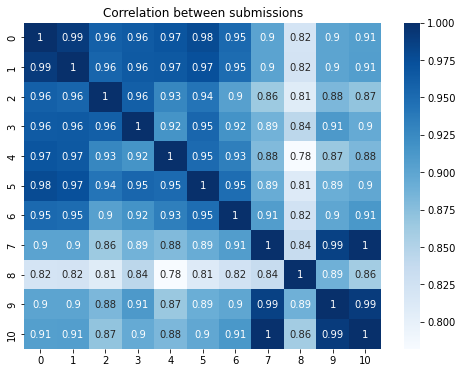

In [78]:
plt.figure(figsize = (8,6))
g = sns.heatmap(df1.corr(),annot=True, cmap='Blues')
g.set_title("Correlation between submissions")
plt.show()

In [79]:
result_1=[0,9]
gm=gmean([ df1.iloc[:,x] for x in result_1])
wm=np.average([ df1.iloc[:,x] for x in result_1],axis=0,weights=[2,1])

In [80]:
subgm=slist.iloc[:,:1].copy(); subgm["target"]=gm #
subwm=slist.iloc[:,:1].copy(); subwm["target"]=wm  #

subgm.set_index("id").to_csv("8.submission분류_기하평균.csv")
subwm.set_index("id").to_csv("8.submission분류_가중평균.csv")

## result

In [81]:
print(f'기존 값 : {sorted(score)}')
#  가장 높은 서브미션
#                     0.80791 > ★★         0.80531 < ★★
#   모든 서브미션 이용
# 1. 앙상블           [0~9]                   [1~9]
#   산술평균          0.80637                0.80582   
#   기하평균          0.80620                0.80544
#   가중평균          0.80704 ★             0.80642 ★★
#   멱평균 p= 2       0.80634                0.80595
#          p= 3.5     0.80620                0.80598
#          p= 5       0.80605                0.80594

#   점수가 높은 서브미션 이용
# 2. 앙상블           [0,1,2,3,4]            [1,2,3,4]
#    산술평균         0.80568                0.80538
#    기하평균         0.80708                0.80606
#    가중평군         0.80726 ★★ 가장 높음 0.80618 ★
#    멱평균 p= 2      0.80563                0.80534
#           p= 3.5    0.80527                0.80495
#           p= 5      0.80484                0.80450

#   가장 높은 서브미션과 상관관계가 높은 서브미션 이용
# 3. 앙상블          [0,1,2,5,6]             [1,2,5,6]
#    산술평균         0.80568                0.80538
#    기하평균         0.80659                0.80552
#    가중평군         0.80710 ★             0.80587 ★
#    멱평균 p= 2      0.80563                0.80534
#           p= 3.5    0.80527                0.80495
#           p= 5      0.80484                0.80450

#   가장 높은 서브미션과 상관관계가 낮은 서브미션 이용
# 4. 앙상블           [0,8,9]                [1,7,8,9]    [1,7,8]       [1,3,4,7]
#    산술평균         0.80309                0.80538 ★   0.80309       0.80538
#    기하평균         0.80128                0.79837      0.79863       0.80506
#    가중평군         0.80408 ★             0.80309      0.80390 ★    0.80645 ★
#    멱평균 p= 2      0.80263                0.80534      0.80263       0.80534
#           p= 3.5    0.80172                0.80495      0.80172       0.80495
#           p= 5      0.80092                0.80450      0.80092       0.80450


기존 값 : ['0.75788', '0.77931', '0.79556', '0.80038', '0.80175', '0.80289', '0.80314', '0.80399', '0.80531']


- 가장 높은 서브미션을 빼고 진행하였더니 앙상블로 인해 모델이 더 좋아짐   가장 높은 걸 빼고 진행하게 더 좋은가?

- 멱평균의 p 값이 증가할수록 점수가 안좋아진다.

- 상관관계가 낮은 서브미션과의 앙상블이 더 좋은 결과일 것이라 예측하였으나 그렇지 않음.

- 대체로 가중평균에서 가장 뛰어난 값을 도출할 수 있었다.  ( 가중치 설정을 잘못한 것인가? 아니면 원래 이렇게 나오는 것인가 )

## 회귀문제

#### 0.83386 가 공개된 코드에서 가장 높은 점수

In [100]:
folder = '회귀submission'
nf = 0
score=[]
for f in os.listdir(folder):
    ext = os.path.splitext(f)[-1]
    if ext == '.csv': 
        s = pd.read_csv(folder+"/"+f)
    else: 
        continue
    score_1=(os.path.splitext(f)[-2].split(" "))[-1]
    score.append(score_1)
    if len(s.columns) !=2:
        continue
    if nf == 0: 
        slist = s
    else: 
        slist = pd.merge(slist, s, on="ID")
    nf += 1
print(score)

['1.02655', '0.99025', '0.89237', '1.01877', '0.93704', '0.89552', '1.02147', '0.88263']


In [101]:
ko=[7,4,1,5,3,2,6,0]
df1=slist.iloc[:,1:]
df1.columns=ko
df1=df1[[0,1,2,3,4,5,6,7]]

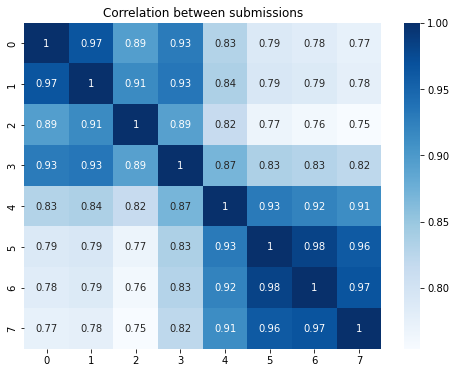

In [102]:
plt.figure(figsize = (8,6))
g = sns.heatmap(df1.corr(),annot=True, cmap='Blues')
g.set_title("Correlation between submissions")
plt.show()

### (1) 전부다 앙상블 했을 때

In [103]:
result_1=np.arange(0,8)
gm=gmean([ df1.iloc[:,x] for x in result_1])
wm=np.average([ df1.iloc[:,x] for x in result_1],axis=0,weights=[len(ko)-x for x in result_1])

In [104]:
subgm=slist.iloc[:,:1].copy(); subgm["item_cnt_month"]=gm # 
subwm=slist.iloc[:,:1].copy(); subwm["item_cnt_month"]=wm # 

In [105]:
subgm.set_index("ID").to_csv("1.submission회귀_기하평균.csv")
subwm.set_index("ID").to_csv("1.submission회귀_가중평균.csv")

In [106]:
def avg(p,k=" ",NUM=" "):
    pred = 0
    for j in range(nf): pred = pred + slist.iloc[:,j+1]**p 
    pred = pred / nf    
    pred = pred**(1/p)

    submission = pd.DataFrame({'ID': slist.ID, 'item_cnt_month': pred})
    t = pd.Timestamp.now()
    fname = f"{NUM}. p{p}mean_submission{k}_{t.month:02}{t.day:02}_{t.hour:02}{t.minute:02}.csv"
    submission.to_csv(fname, index=False)

In [107]:
avg(1,"_회귀_산술평균",NUM="1")   #
avg(2,"_회귀",NUM="1")   #
avg(3.5,"_회귀",NUM="1") #
avg(5,"_회귀",NUM="1")   #

### (2) 점수가 좋은 것끼리 앙상블 한 경우

In [108]:
result_1=[0,1,2,3]
gm=gmean([ df1.iloc[:,x] for x in result_1])
wm=np.average([ df1.iloc[:,x] for x in result_1],axis=0,weights=[4,3,2,1])
subgm=slist.iloc[:,:1].copy(); subgm["item_cnt_month"]=gm #
subwm=slist.iloc[:,:1].copy(); subwm["item_cnt_month"]=wm #

In [109]:
subgm.set_index("ID").to_csv("2.submission회귀_기하평균.csv")
subwm.set_index("ID").to_csv("2.submission회귀_가중평균.csv")

In [110]:
slist1=df1[result_1]
nf=len(result_1)
avg(1,"_회귀_산술평균","2")   #
avg(2,"_회귀",NUM="2")   #
avg(3.5,"_회귀",NUM="2") #
avg(5,"_회귀",NUM="2")   #

### (3) 가장 점수가 좋은 것과 상관관계가 높은 것끼리 했을 때

In [111]:
result_1=[0,1,3]
gm=gmean([ df1.iloc[:,x] for x in result_1])
wm=np.average([ df1.iloc[:,x] for x in result_1],axis=0,weights=[3,2,1])
subgm=slist.iloc[:,:1].copy(); subgm["item_cnt_month"]=gm #
subwm=slist.iloc[:,:1].copy(); subwm["item_cnt_month"]=wm  #

In [112]:
subgm.set_index("ID").to_csv("3.submission회귀_기하평균.csv")
subwm.set_index("ID").to_csv("3.submission회귀_가중평균.csv")

In [113]:
slist1=df1[result_1]
nf=len(result_1)
avg(1,"_회귀_산술평균","3")   #
avg(2,"_회귀",NUM="3")   #
avg(3.5,"_회귀",NUM="3") #
avg(5,"_회귀",NUM="3")   #

### (4) 가장 점수가 좋은 것과 상관관계가 낮은 것끼리 했을 때

In [114]:
result_1=[0,5,6,7]
gm=gmean([ df1.iloc[:,x] for x in result_1])
wm=np.average([ df1.iloc[:,x] for x in result_1],axis=0,weights=[4,3,2,1])
subgm=slist.iloc[:,:1].copy(); subgm["item_cnt_month"]=gm #
subwm=slist.iloc[:,:1].copy(); subwm["item_cnt_month"]=wm  #

In [115]:
subgm.set_index("ID").to_csv("4.submission회귀_기하평균.csv")
subwm.set_index("ID").to_csv("4.submission회귀_가중평균.csv")

In [116]:
slist1=df1[result_1]
nf=len(result_1)
avg(1,"_회귀_산술평균","4")   #
avg(2,"_회귀",NUM="4")   #
avg(3.5,"_회귀",NUM="4") #
avg(5,"_회귀",NUM="4")   #

In [ ]:
#

In [125]:
result_1=[4,5]
gm=gmean([ df1.iloc[:,x] for x in result_1])
wm=np.average([ df1.iloc[:,x] for x in result_1],axis=0,weights=[2,1])
subgm=slist.iloc[:,:1].copy(); subgm["item_cnt_month"]=gm #
subwm=slist.iloc[:,:1].copy(); subwm["item_cnt_month"]=wm  #

In [126]:
subgm.set_index("ID").to_csv("10.submission회귀_기하평균.csv")
subwm.set_index("ID").to_csv("10.submission회귀_가중평균.csv")

In [120]:
df1

,0,1,2,3,4,5,6,7
0,0.435173,0.541189,0.586481,0.437955,0.632327,0.559430,0.392676,0.467286
1,0.339557,0.469245,0.314648,0.359458,0.088516,0.133858,0.118782,0.146498
2,0.807810,1.054817,0.782429,1.018562,1.025817,0.946685,0.728607,0.645642
3,0.378088,0.598383,0.364795,0.342582,0.295133,0.201182,0.152417,0.177037
4,4.806588,2.057570,3.168668,4.305273,0.833069,0.133858,0.118782,0.146498
...,...,...,...,...,...,...,...,...
214195,0.087205,0.112846,0.079866,0.106623,0.238099,0.410016,0.339938,0.296735
214196,0.022706,0.036390,0.041092,0.015386,0.124925,0.133858,0.118782,0.146498
214197,0.045608,0.055449,0.083352,0.028698,0.090395,0.120889,0.111934,0.146498
214198,0.024647,0.035515,0.048830,0.017358,0.089972,0.133858,0.118782,0.146498


In [121]:
slist

,ID,item_cnt_month_x,item_cnt_month_y,item_cnt_month_x,item_cnt_month_y,item_cnt_month_x,item_cnt_month_y,item_cnt_month_x,item_cnt_month_y
0,0,0.467286,0.632327,0.541189,0.559430,0.437955,0.586481,0.392676,0.435173
1,1,0.146498,0.088516,0.469245,0.133858,0.359458,0.314648,0.118782,0.339557
2,2,0.645642,1.025817,1.054817,0.946685,1.018562,0.782429,0.728607,0.807810
3,3,0.177037,0.295133,0.598383,0.201182,0.342582,0.364795,0.152417,0.378088
4,4,0.146498,0.833069,2.057570,0.133858,4.305273,3.168668,0.118782,4.806588
...,...,...,...,...,...,...,...,...,...
214195,214195,0.296735,0.238099,0.112846,0.410016,0.106623,0.079866,0.339938,0.087205
214196,214196,0.146498,0.124925,0.036390,0.133858,0.015386,0.041092,0.118782,0.022706
214197,214197,0.146498,0.090395,0.055449,0.120889,0.028698,0.083352,0.111934,0.045608
214198,214198,0.146498,0.089972,0.035515,0.133858,0.017358,0.048830,0.118782,0.024647


In [124]:
df1["8"]=pd.read_csv(r"10.submission회귀_가중평균.csv")["item_cnt_month"]
df1["9"]=pd.read_csv(r"10.submission회귀_기하평균.csv")["item_cnt_month"]
result_1=[0,1,8]
result_2=[0,1,9]
mm=[df1.iloc[:,x] for x in result_2].mean()
wm=np.average([ df1.iloc[:,x] for x in result_1],axis=0,weights=[3,2,1])
subgm=slist.iloc[:,:1].copy(); subgm["item_cnt_month"]=mm #
subwm=slist.iloc[:,:1].copy(); subwm["item_cnt_month"]=wm  #
subgm.set_index("ID").to_csv("10.submission회귀_평균.csv")
subwm.set_index("ID").to_csv("10.submission회귀_가중평균.csv")

In [ ]:
slist1=df1[result_1]
nf=len(result_1)
avg(1,"_회귀_산술평균","4")   #
avg(2,"_회귀",NUM="4")   #
avg(3.5,"_회귀",NUM="4") #
avg(5,"_회귀",NUM="4")   #

## result

In [99]:
print(f'기존 값 : {sorted(score)}')
# 1. 앙상블
#   산술평균        0.92427
#   기하평균        0.96986
#   가중평균        0.89755
#   멱평균 p= 2     0.90334
#          p= 3.5   0.89504
#          p= 5     0.89462

# 2. 앙상블
#    산술평균       0.95538
#    기하평균       0.88669
#    가중평군       0.87660
#    멱평균 p= 2    0.92959
#           p= 3.5  0.91665
#           p= 5

# 3. 앙상블
#    산술평균             0.94073
#    기하평균             0.89331
#    가중평군             0.88403
#    멱평균 p= 2          0.92082
#           p= 3.5
#           p= 5

# 4. 앙상블
#    산술평균 
#    기하평균 
#    가중평군
#    멱평균 p= 2
#           p= 3.5
#           p= 5

기존 값 : ['0.88263', '0.89237', '0.89552', '0.93704', '0.99025', '1.01877', '1.02147', '1.02655']
